<a href="https://colab.research.google.com/github/elka97/GB_NN/blob/main/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Практическое задание
Вариант 1. (простой)

1. обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
2. оценить рост точности при увеличении ширины сети (больше ядер)
3. оценить рост точности при увеличении глубины сети (больше слоев)
(опциционально)сравнить с точностью полносвязной сети для этой выборки

In [1]:
# from __future__ import print_function
import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
import numpy as np

### Load, pre-processing

In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
num_classes = len(classes)

In [3]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

170508288/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [4]:
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# mashtabizaciya данных [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

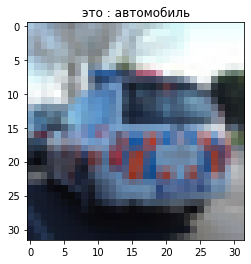

In [5]:
N = 1131
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [46]:
# установка параметров нейросети
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

batch_size = 32
epochs = 5
data_augmentation = False

### Methods

In [47]:
def run_model(_m, _batch_size=32, _epochs=10, _data_augmentation=False):
  if not _data_augmentation:
      print('Не используется data augmentation')
      _m.fit(x_train, y_train,
                batch_size=_batch_size,
                epochs=_epochs,
                validation_data=(x_test, y_test),
                shuffle=True)
  else:
      print('Использование data augmentation в реальном времени')
      # Препроцессинг и data augmentation в реальном времени:
      datagen = ImageDataGenerator(
          featurewise_center=False,
          samplewise_center=False,
          featurewise_std_normalization=False,
          samplewise_std_normalization=False,
          zca_whitening=False, 
          zca_epsilon=1e-06, 
          rotation_range=5, 
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0., 
          zoom_range=0., 
          channel_shift_range=0.,
          fill_mode='nearest',
          cval=0.,
          horizontal_flip=True,
          vertical_flip=False,
          rescale=None,
          preprocessing_function=None,
          data_format=None,
          validation_split=0.0)      

      # compute quantities required for featurewise normalization
      # (std, mean, and principal components if ZCA whitening is applied)
      datagen.fit(x_train)

      # fits the model on batches with real-time data augmentation:   
      #TF >= 2.1
      _m.fit(datagen.flow(x_train, y_train, batch_size=_batch_size), steps_per_epoch=len(x_train) // _batch_size, epochs=_epochs)

  # # сохранение модели и весов
  # if not os.path.isdir(save_dir):
  #   os.makedirs(save_dir)
  # model_path = os.path.join(save_dir, model_name)
  # _m.save(model_path)
  # print('сохранить обученную модель как %s ' % model_path)

  # проверка работы обученной модели
  scores = _m.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

  return

In [48]:
def build_model(_model_conf):  
  _model = Sequential()
  i=0

  # конфигурирование слоев нейросети
  for key, val in _model_conf.items():
    # print(key,  val)

    if "conv" in key:      
      _filters, _kernl_size, _strides, _pad = val[0], val[1], val[2], val[3]
      # print(_filters, _kernl_size, _strides, _pad)  #, val[1], val[3], val[2]
      if i==0:
        _model.add(Conv2D(_filters, _kernl_size, padding=str(_pad), activation='relu', strides=_strides, input_shape=x_train.shape[1:]))
      else:
        _model.add(Conv2D(_filters, _kernl_size, padding=str(_pad), activation='relu', strides=_strides))
      i+=1
      # print(i)
    if "pool" in key:
      _model.add(MaxPooling2D(pool_size=(val[0], val[0]), strides=val[1]))
      _model.add(Dropout(0.25))
    if "flat" in key:
      _model.add(Flatten())
    # полносвязные слои нейронной сети
    if "dense" in key:
      _model.add(Dense(val[0], activation='relu'))  

  #  output layer
  _model.add(Dropout(0.5))
  _model.add(Dense(num_classes, activation='softmax')) 
  # компиляция модели
  _model.compile(loss='categorical_crossentropy',
                optimizer='SGD',
                metrics=['accuracy'])  
  # вывод описания созданной модели
  _model.summary()
  return _model

### Пример  из урока (на Keras более сложной сверточной нейронной сети) - базовая моделЬ

In [ ]:
# conv 32 same 3x3
# conv 32 valid 3x3
# pooling 2x2
# conv 64 same 3x3
# conv 64 valid 3x3
# pooling 2x2
# flattern
# Dense 512
# dense output

In [50]:
model_conf={"conv1": (32, 3, 1, "same"), "conv2":(32, 3, 1, "valid") , "pool1":(2,1), 
            "conv3":(64, 3, 1, "same"), "conv4":(64, 3, 1, "valid"), "pool2":(2,1), 
            "flat": (), "dense1":(512,)}
model = build_model(model_conf)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_48 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 conv2d_50 (Conv2D)          (None, 27, 27, 64)        36928     
                                                     

In [51]:
run_model(model, batch_size, epochs, False)
run_model(model, batch_size, epochs, True)

Не используется data augmentation
Epoch 1/5
1563/1563 [==============================] - 16s 10ms/step - loss: 1.8556 - accuracy: 0.3281 - val_loss: 1.5613 - val_accuracy: 0.4564
Epoch 2/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5000 - accuracy: 0.4598 - val_loss: 1.3393 - val_accuracy: 0.5318
Epoch 3/5
1563/1563 [==============================] - 15s 9ms/step - loss: 1.3021 - accuracy: 0.5373 - val_loss: 1.2179 - val_accuracy: 0.5738
Epoch 4/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1494 - accuracy: 0.5920 - val_loss: 1.0378 - val_accuracy: 0.6378
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.9695 - accuracy: 0.6588
Test loss: 0.9695219993591309
Test accuracy: 0.6588000059127808
Использование data augmentation в реальном времени
Epoch 1/5
1562/1562 [==============================] - 109s 27ms/step - loss: 1.1315 - accuracy: 0.6020
Epoch 2/5
1562/1562 [==============================] - 42s 27ms/step - 

с data augmentation дела идут получше (больше примеров в разных ракурсах, освещением)

### В стиле AlexNet (больше ядер+больше слоев)

In [ ]:
# AlexNet с картинки:
# 1. Conv 11x11, stride=4 96 kernels слоi/input
# Pool 3x3, stride=2
# 2. Conv 5x5, pad=2 256 kernels  
# Pool 3x3, stride=2
# 3. Conv 3x3, pad=1 384 kernels 
# 4. Conv 3x3, pad=1 384 kernels  
# 5. Conv 3x3, pad=1 256 kernels  
# MaxPool 3x3, stride=2
# сглаживание CNN выхода чтобы можно было его присоединить к полносвязному слою
# model.add(Flatten())
# полносвязные слои нейронной сети
# 1. Dense(4096, activation='relu'))
# 2. Dense(4096, activation='relu'))
# выходной слой с функцией активации softmax
# 3. output Dense(num_classes)

In [ ]:
model_conf={"conv1": (96, 11, 4, "same"), "pool1":(3,2), 
            "conv2":(256, 5, 1, "same") , "pool2":(3,2), 
            "conv3":(384, 3, 1, "valid"), "conv4":(384, 3, 1, "valid"), "conv5":(256, 3, 1, "valid"), "pool3":(3,2), 
            "flat": (), "dense1":(4096,), "dense2":(4096,)}
model = build_model(model_conf)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_75. Consider increasing the input size. Received input shape [None, 1, 1, 256] which would produce output shape with a zero or negative value in a dimension.


**ошибка, на данном датасете эта архитектура не сходится**

In [53]:
model_conf={"conv1":(96, 6, 2, "same"), "pool1":(3,1), 
            "conv2":(64, 5, 1, "valid"), "pool2":(3,1),             
            "conv3":(86, 3, 1, "valid"), "conv4":(86, 3, 1, "valid"), "pool3":(3,1), 
            "flat": (), "dense1":(1024,), "dense2":(1024,)}
model = build_model(model_conf)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 16, 16, 96)        10464     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 96)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 14, 14, 96)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 10, 10, 64)        153664    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 8, 8, 64)        

In [54]:
run_model(model, batch_size, epochs, False)
run_model(model, batch_size, epochs, True)

Не используется data augmentation
Epoch 1/5
1563/1563 [==============================] - 12s 7ms/step - loss: 2.1335 - accuracy: 0.1723 - val_loss: 1.9287 - val_accuracy: 0.2494
Epoch 2/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8081 - accuracy: 0.3151 - val_loss: 1.6671 - val_accuracy: 0.3953
Epoch 3/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5977 - accuracy: 0.4082 - val_loss: 1.6455 - val_accuracy: 0.4095
Epoch 4/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4732 - accuracy: 0.4596 - val_loss: 1.4982 - val_accuracy: 0.4482
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 1.3537 - accuracy: 0.5011
Test loss: 1.3537120819091797
Test accuracy: 0.5011000037193298
Использование data augmentation в реальном времени
Epoch 1/5
1562/1562 [==============================] - 42s 26ms/step - loss: 1.3949 - accuracy: 0.4967
Epoch 2/5
1562/1562 [==============================] - 41s 26ms/step - lo

архитектура (больше ядер+больше слоев) проигрывает базовоi модели, как с data augmentation так и без

### базовая модель + больше ядер

In [55]:
model_conf={"conv1": (64, 3, 1, "same"), "conv2":(64, 3, 1, "valid") , "pool1":(2,1), 
            "conv3":(128, 3, 1, "same"), "conv4":(128, 3, 1, "valid"), "pool2":(2,1), 
            "flat": (), "dense1":(512,)}

model = build_model(model_conf)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_59 (Conv2D)          (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 29, 29, 64)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 conv2d_61 (Conv2D)          (None, 27, 27, 128)       147584    
                                                     

In [56]:
run_model(model, batch_size, epochs, False)
run_model(model, batch_size, epochs, True)

Не используется data augmentation
Epoch 1/5
1563/1563 [==============================] - 24s 15ms/step - loss: 1.8476 - accuracy: 0.3275 - val_loss: 1.5432 - val_accuracy: 0.4404
Epoch 2/5
1563/1563 [==============================] - 22s 14ms/step - loss: 1.4530 - accuracy: 0.4775 - val_loss: 1.4489 - val_accuracy: 0.4922
Epoch 3/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.2528 - accuracy: 0.5535 - val_loss: 1.1901 - val_accuracy: 0.5829
Epoch 4/5
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1059 - accuracy: 0.6090 - val_loss: 0.9970 - val_accuracy: 0.6494
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.9791 - accuracy: 0.6545
Test loss: 0.9791275262832642
Test accuracy: 0.6545000076293945
Использование data augmentation в реальном времени
Epoch 1/5
1562/1562 [==============================] - 48s 30ms/step - loss: 1.0923 - accuracy: 0.6158
Epoch 2/5
1562/1562 [==============================] - 46s 30ms/step 

0.658/0.72 # base
0.654/0.733 # more filters(kernels)

увеличение количества ядер (фильтров) дает сравнимый с  базовым результат, не имеет смысла

### базовая модель + больше слоев1

In [58]:
model_conf={"conv1": (32, 3, 1, "same"), "conv2":(32, 3, 1, "valid"), "pool1":(2,1), 
            "conv3":(64, 3, 1, "same"), "conv4":(64, 3, 1, "valid"), "conv5":(48, 3, 1, "valid"), "pool2":(2,1), 
            "conv6":(32, 3, 1, "same"), "conv7":(32, 3, 1, "valid"), "pool3":(2,1), 
            "flat": (), "dense1":(512,)}
model = build_model(model_conf)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_63 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 conv2d_65 (Conv2D)          (None, 27, 27, 64)        36928     
                                                     

In [59]:
run_model(model, batch_size, epochs, False)
run_model(model, batch_size, epochs, True)

Не используется data augmentation
Epoch 1/5
1563/1563 [==============================] - 17s 10ms/step - loss: 2.0382 - accuracy: 0.2448 - val_loss: 2.3362 - val_accuracy: 0.2250
Epoch 2/5
1563/1563 [==============================] - 15s 10ms/step - loss: 1.7009 - accuracy: 0.3795 - val_loss: 1.6612 - val_accuracy: 0.4040
Epoch 3/5
1563/1563 [==============================] - 17s 11ms/step - loss: 1.5443 - accuracy: 0.4389 - val_loss: 1.4924 - val_accuracy: 0.4695
Epoch 4/5
1563/1563 [==============================] - 15s 10ms/step - loss: 1.3950 - accuracy: 0.4953 - val_loss: 1.2888 - val_accuracy: 0.5435
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 1.3216 - accuracy: 0.5277
Test loss: 1.3215715885162354
Test accuracy: 0.5277000069618225
Использование data augmentation в реальном времени
Epoch 1/5
1562/1562 [==============================] - 44s 28ms/step - loss: 1.3237 - accuracy: 0.5271
Epoch 2/5
1562/1562 [==============================] - 43s 28ms/step 

слабенький вариант, слои добавлены везде)

### базовая модель + больше слоев2

In [60]:
model_conf={"conv1": (32, 3, 1, "same"), "conv2":(32, 3, 1, "valid") , "pool1":(2,1), 
            "conv3":(64, 3, 1, "same"), "conv4":(64, 3, 1, "valid"), "pool2":(2,1), 
            "conv3":(32, 3, 1, "same"), "conv4":(32, 3, 1, "valid"), "pool2":(2,1), 
            "flat": (), "dense1":(512,)}
            
model = build_model(model_conf)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_70 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_71 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 conv2d_72 (Conv2D)          (None, 27, 27, 32)        9248      
                                                     

In [61]:
run_model(model, batch_size, epochs, False)
run_model(model, batch_size, epochs, True)

Не используется data augmentation
Epoch 1/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.9380 - accuracy: 0.2977 - val_loss: 1.8903 - val_accuracy: 0.3277
Epoch 2/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5686 - accuracy: 0.4367 - val_loss: 1.3985 - val_accuracy: 0.5005
Epoch 3/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3589 - accuracy: 0.5117 - val_loss: 1.3512 - val_accuracy: 0.5264
Epoch 4/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2267 - accuracy: 0.5606 - val_loss: 1.2609 - val_accuracy: 0.5548
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 1.2633 - accuracy: 0.5746
Test loss: 1.263279676437378
Test accuracy: 0.5745999813079834
Использование data augmentation в реальном времени
Epoch 1/5
1562/1562 [==============================] - 41s 26ms/step - loss: 1.2027 - accuracy: 0.5719
Epoch 2/5
1562/1562 [==============================] - 41s 26ms/step - los

0.5745/0.6632

хуже чем базовыi результат, не имеет смысла 

Мария, как вы нашли такой хороший базовый вариант?

In [62]:
# поучим еще 3 итерации/эпохи

run_model(model, batch_size, 3, False)
run_model(model, batch_size, 3, True)

Не используется data augmentation
Epoch 1/3
1563/1563 [==============================] - 12s 7ms/step - loss: 0.8647 - accuracy: 0.6953 - val_loss: 0.8368 - val_accuracy: 0.7097
Epoch 2/3
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8025 - accuracy: 0.7169 - val_loss: 0.8040 - val_accuracy: 0.7185
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.7897 - accuracy: 0.7267
Test loss: 0.7896525859832764
Test accuracy: 0.7267000079154968
Использование data augmentation в реальном времени
Epoch 1/3
1562/1562 [==============================] - 41s 26ms/step - loss: 0.9460 - accuracy: 0.6688
Epoch 2/3
1562/1562 [==============================] - 41s 26ms/step - loss: 0.9177 - accuracy: 0.6754
Epoch 3/3
313/313 [==============================] - 1s 5ms/step - loss: 0.7906 - accuracy: 0.7309
Test loss: 0.7906155586242676
Test accuracy: 0.73089998960495


### вывод

 имеет смысл:
1. искать оптимальное количство слоев и фильтров/ядер
2.  более длинное обучение, порциями